### 数据获取：
1. 从gong下载对应时间附近ha的fz文件 https://gong2.nso.edu/archive/patch.pl?menutype=hAlpha
2. 从jsoc下载对应时间附近hmi的fits文件(45s) http://jsoc.stanford.edu/ajax/lookdata.html?ds=hmi.M_45s
### 使用方法
根据此ipynb文件中代码块顺序逐个运行即可
需要修改的地方有注释标注


In [1]:
# 解压所有fz文件
import os
path = 'D:\\labeledFilaments\\manualsearch'
files = os.listdir(path)
for file in files:
    !funpack $path\\$file

Error: can't find or read input file D:\labeledFilaments\manualsearch\\file
Input and output files are unchanged.
Error: input compressed file D:\labeledFilaments\manualsearch\\prc.ipynb
 does not have the default .fz suffix.
Input and output files are unchanged.


In [ ]:
# 删除文件名站台后缀 保留日期时间
import os
path = 'D:\\labeledFilaments\\manualsearch\\'
files = os.listdir(path)
for file in files:
    if file.endswith('.fts') or file.endswith('.fits'):
        os.rename(path+file, path+file[:14]+'.fits')


<Helioprojective Frame (obstime=2015-12-20T14:48:14.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2015-12-20T14:48:14.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0., -1.55591483, 1.47177238e+11)>)>


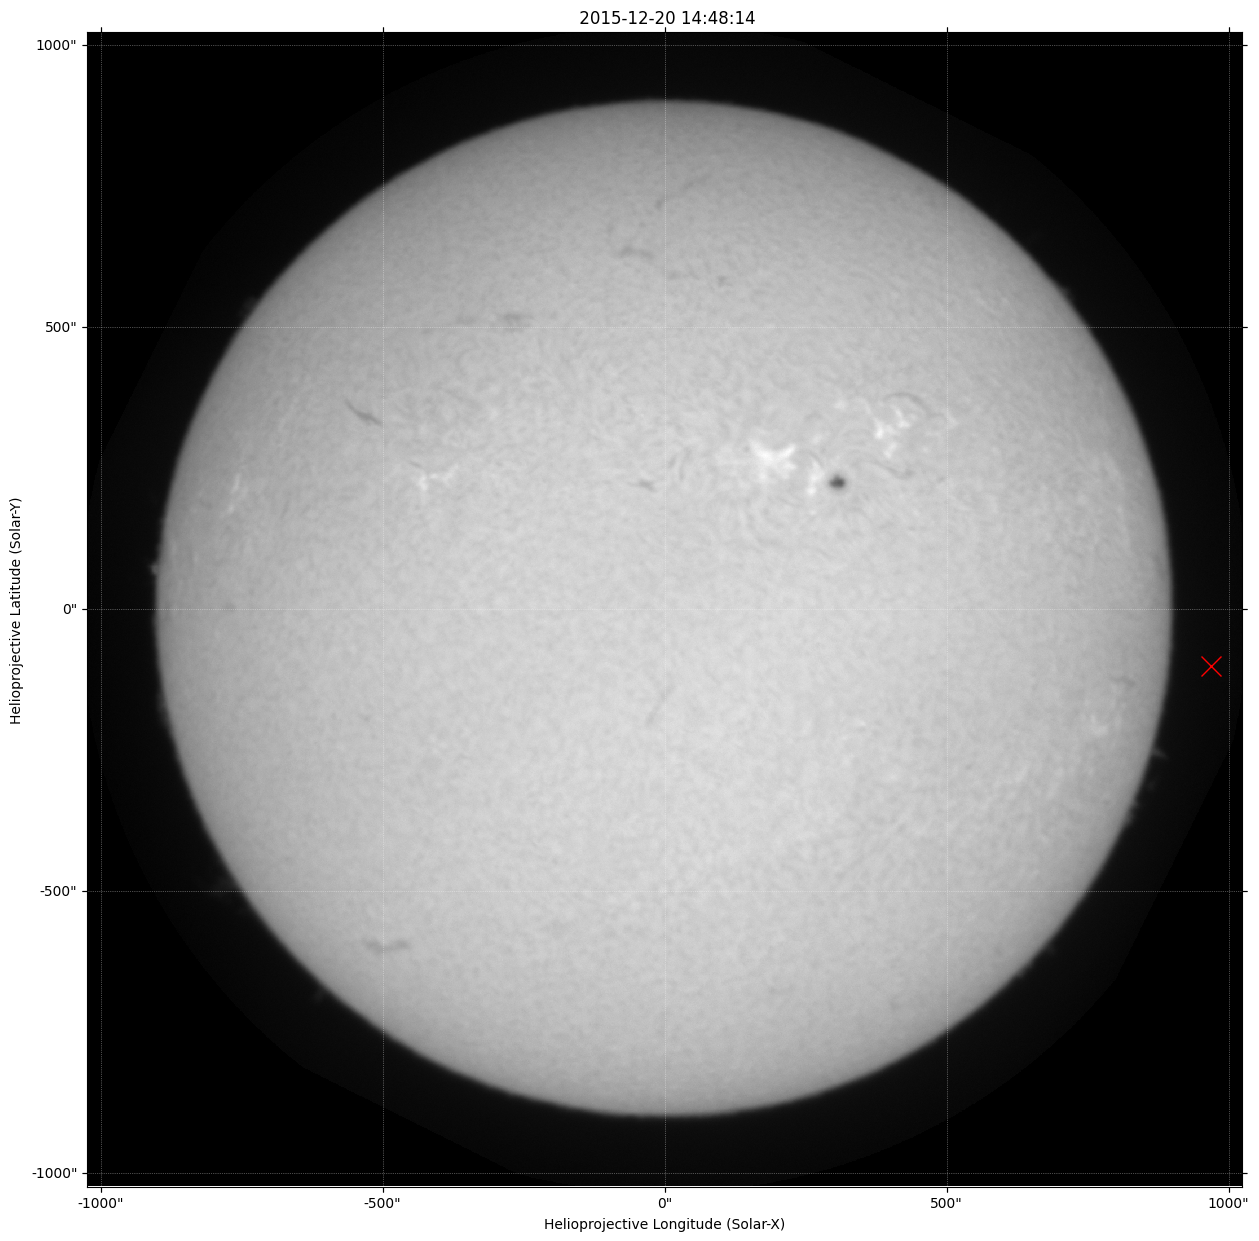

In [352]:
# 预览ha图像 观察给定坐标位置附近是否有暗条
import astropy.units as u
import sunpy.map
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.io import fits
import numpy as np
from sunpy.coordinates import frames
from sunpy.map.header_helper import make_fitswcs_header

# 要查看的ha文件名
timestr = '20151220144814.fits'[:14]

hdul = fits.open(f'D:\\labeledFilaments\\manualsearch\\{timestr}.fits')
data, header = hdul[0].data, hdul[0].header
header['cunit1'] = 'arcsec' 
header['cunit2'] = 'arcsec' 
header['obs_mode'] = 'full disk'
header['obs_prog'] = 'halpha patrol'

reference_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, obstime = timestr, observer = 'earth', frame = frames.Helioprojective)
header = make_fitswcs_header(data, reference_coord)
amap = sunpy.map.Map(data, header) 

# amap = sunpy.map.Map('D:\\labeledFilaments\\manualsearch\\20100703073314.fits')

amap.meta['WAVEUNIT'] = 'angstrom'
amap.meta['cunit1'] = 'arcsec'
amap.meta['cunit2'] = 'arcsec'

print(amap.coordinate_frame)

if 'center_x' not in header or 'center_y' not in header:
    header['center_x'] = header['crpix1']
    header['center_y'] = header['crpix2']

origin = np.array([header['center_x'], header['center_y']])

fig = plt.figure(1, [15,15])
ax = plt.subplot(projection=amap)
all_coord = sunpy.map.all_coordinates_from_map(amap)
# hgs = all_coord.transform_to('heliographic_stonyhurst')

# 欧阳雨数据中LC坐标
LCstr = 'L154C096'
L, C = int(LCstr[1:4]), int(LCstr[5:8])
point = SkyCoord(L*u.deg, -(C-90)*u.deg, frame='heliographic_carrington', observer='earth', obstime=timestr)
relative = np.array([910   ,   241])

ax.plot_coord(point, 'rx', fillstyle='none', markersize=15, label='Point')
locat = np.add(origin, relative)
#plt.plot(locat[0], locat[1], 'bx', fillstyle='none', markersize=15, label='Point')

amap.plot()

[[1870  917]
 [1796  815]]


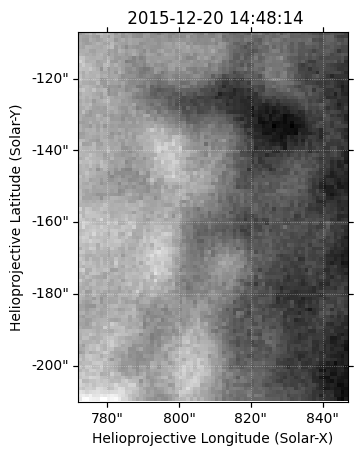

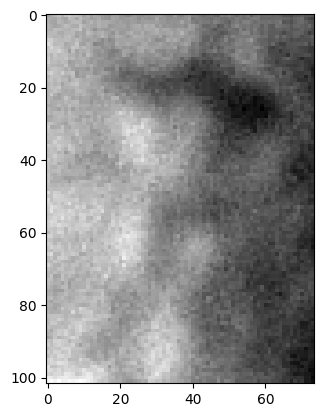

In [353]:
# 如果有暗条，用其他软件仔细查看暗条的右上角、左下角坐标 否则返回上一步，换下一个文件
#TOP_RIGHT, BOT_LEFT
TR = [846,-107]
BL = [772,-209]

snap = np.array([TR, BL])
TR_abs = np.array([TR[0]+origin[0], TR[1]+origin[1]])
BL_abs = np.array([BL[0]+origin[0], BL[1]+origin[1]])

snap_idx = np.int32(snap + np.array([[origin[0], origin[1]], [origin[0], origin[1]]]))
print(snap_idx)
top_right = SkyCoord(snap[0][0]*u.arcsec, snap[0][1]*u.arcsec, frame=amap.coordinate_frame)
bottom_left = SkyCoord(snap[1][0]*u.arcsec, snap[1][1]*u.arcsec, frame=amap.coordinate_frame)
submap = amap.submap(bottom_left, top_right=top_right)
fig = plt.figure()
ax1 = plt.subplot(projection=submap)
image = submap.plot(axes=ax1)
plt.show()
subdata = data[snap_idx[1][1]:snap_idx[0][1], snap_idx[1][0]:snap_idx[0][0]]
rev = np.flipud(subdata)

plt.imshow(rev, cmap='gray')
plt.show()

# 展示截出来的暗条


In [354]:
# 将截取ha图写入csv文件 将暗条时间、坐标、类型写入data.txt
import csv

matrix = rev
# 根据欧阳雨数据文件 标定暗条类型 第一位手征性 第二位形状
# sinistral=1 dextral=2 rope=1 sheared=2 unidentified=0
sfx = '_12'
csvname = timestr + sfx + '.csv'

with open('data.txt', 'a') as f:
    f.write(timestr + str(TR) + str(BL)+ ' ' + sfx[1:] +'\n')

with open(csvname, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for row in matrix:
        writer.writerow(row)

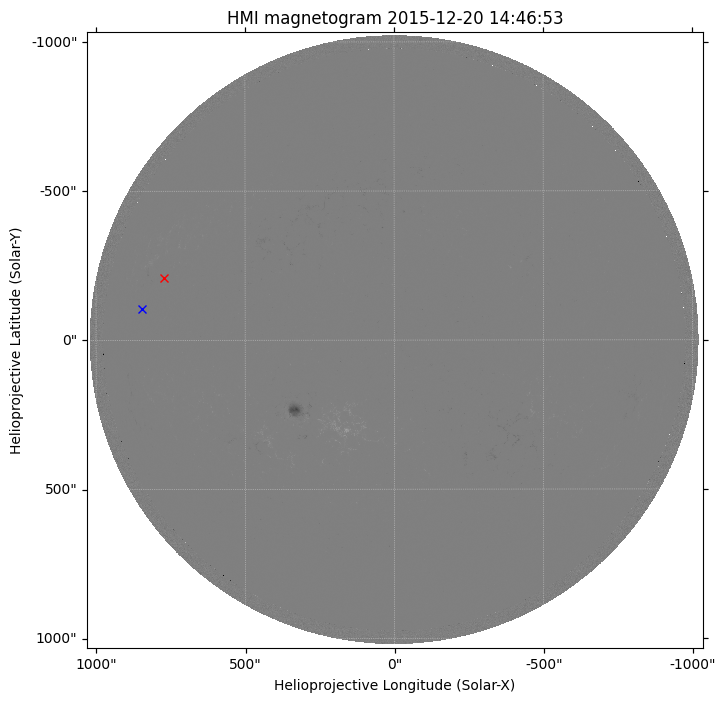

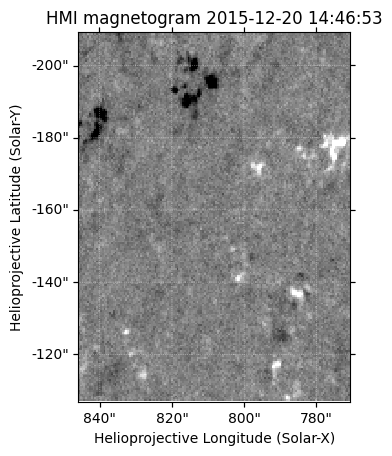

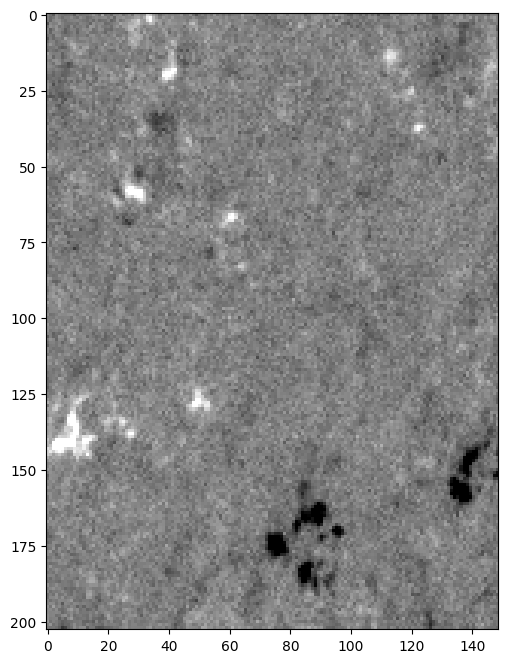

In [355]:
# 找到对应的磁图文件 画出上述坐标对应暗条的位置
import matplotlib.colors

# 要查看的磁图文件名
fname = 'hmi.m_45s.20151220_144800_TAI.2.magnetogram.fits'
filepath = f'D:\\labeledFilaments\\111\\{fname}'

xmap = sunpy.map.Map(filepath)
hdul = fits.open(filepath)
data, header = hdul[1].data, hdul[1].header
bmap = sunpy.map.Map(data, header)

if 'center_x' not in header or 'center_y' not in header:
    header['center_x'] = header['crpix1']
    header['center_y'] = header['crpix2']

origin = np.array([header['center_x'], header['center_y']])


snap = np.array([TR, BL]) + origin

TR_c = SkyCoord(TR[0]*u.arcsec, TR[1]*u.arcsec, frame='helioprojective', obstime=bmap.date, observer='earth')
BL_c = SkyCoord(BL[0]*u.arcsec, BL[1]*u.arcsec, frame='helioprojective', obstime=bmap.date, observer='earth')


subdata = data[snap_idx[1][1]:snap_idx[0][1], snap_idx[1][0]:snap_idx[0][0]]
rev = np.flipud(subdata)

fig1 = plt.figure(figsize=[8,8])
ax = plt.subplot(projection=xmap)

xmap.plot()
ax.plot_coord(TR_c, 'bx')
ax.plot_coord(BL_c, 'rx')

submap = xmap.submap(bottom_left=BL_c, top_right=TR_c)
subdata1 = submap.data
rev1 = np.fliplr(subdata1)
fig2 = plt.figure()
ax2 = plt.subplot(projection=submap)
image = submap.plot(axes=ax2, cmap='gray', norm=matplotlib.colors.Normalize(vmin=-100, vmax=100))

plt.show()

fig3 = plt.figure(figsize=(8,8))
plt.imshow(rev1, cmap='gray', norm=matplotlib.colors.Normalize(vmin=-100, vmax=100))
plt.show()

In [356]:
# 磁图写入csv
matrix1 = rev1
csvname1 = timestr + sfx + '_mag.csv'

with open(csvname1, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for row in matrix1:
        writer.writerow(row)

In [1]:
# 重命名磁图
import os
path = 'D:\\labeledFilaments\\111\\'
files = os.listdir(path)
with open('data.txt', 'r') as f:
    for line in f:
        timel = line[:10]
        for file in files:
            timel1 = timel[:8] + '_' + timel[8:]
            if timel1 in file:
                os.rename(path+file, line[:14]+'_hmi.fits')


PermissionError: [WinError 32] 另一个程序正在使用此文件，进程无法访问。: 'D:\\labeledFilaments\\111\\hmi.m_45s.20151220_144800_TAI.2.magnetogram.fits' -> '20151220144814_hmi.fits'